In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
import chart_studio.plotly as py
cf.go_offline()

## Data Collection and Data Manipulation

In [3]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [4]:
msft = get_finance_data('msft')

In [5]:
msft

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,12.875640,13.707300,12.852957,13.480484,88871700
2009-02-03,13.495602,14.070205,13.306588,13.987039,86865100
2009-02-04,14.017284,14.365070,13.987041,14.085328,75618000
2009-02-05,13.994601,14.470916,13.798026,14.395311,75195200
2009-02-06,14.486035,15.068199,14.410429,14.864063,86746000
...,...,...,...,...,...
2021-10-15,302.339996,304.450012,300.519989,304.209991,25374700
2021-10-18,303.570007,308.209991,302.690002,307.290009,22729300
2021-10-19,308.350006,309.299988,307.220001,308.230011,17682100


In [6]:
msft_close = msft[['Close']]

## Data Visualization

In [7]:
msft_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [8]:
msft['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

## Modeling

In [9]:
msft_close

,Close
Date,
2009-02-02,13.480484
2009-02-03,13.987039
2009-02-04,14.085328
2009-02-05,14.395311
2009-02-06,14.864063
...,...
2021-10-15,304.209991
2021-10-18,307.290009
2021-10-19,308.230011


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [10]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(msft_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 6.788201
p-value: 1.000000


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

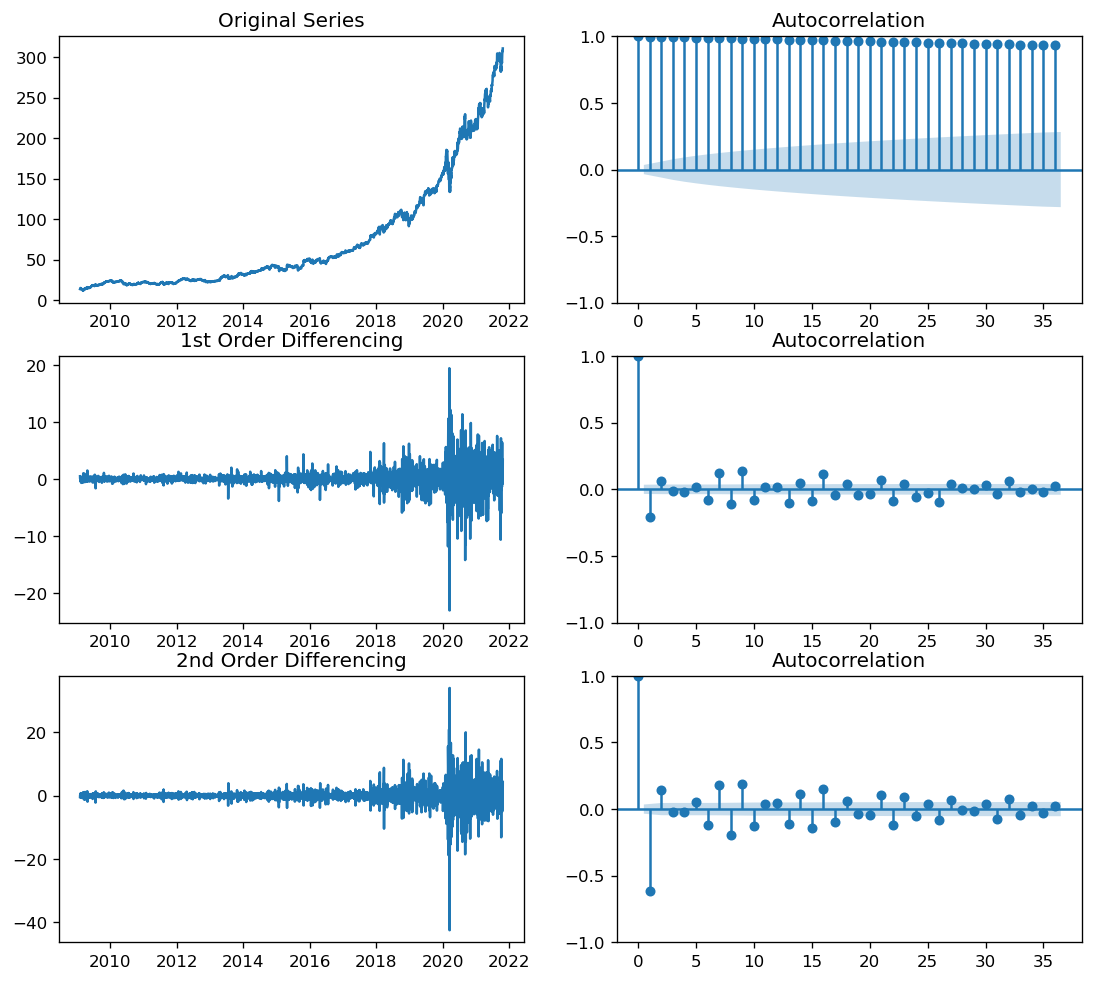

In [13]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(msft_close); axes[0, 0].set_title('Original Series')
plot_acf(msft_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(msft_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(msft_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(msft_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(msft_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



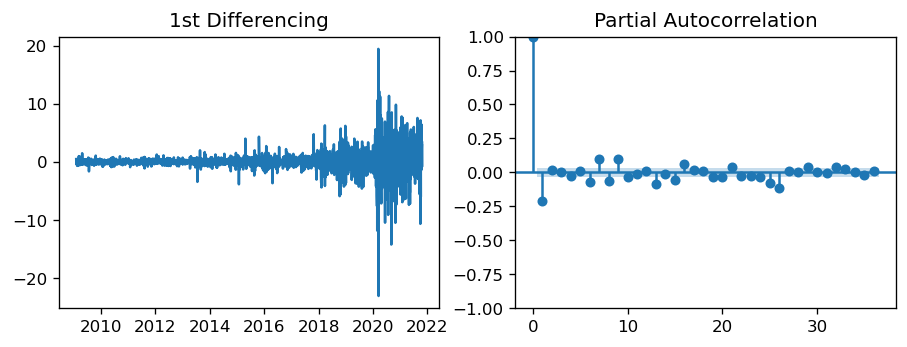

In [16]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(msft_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(msft_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significantly well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

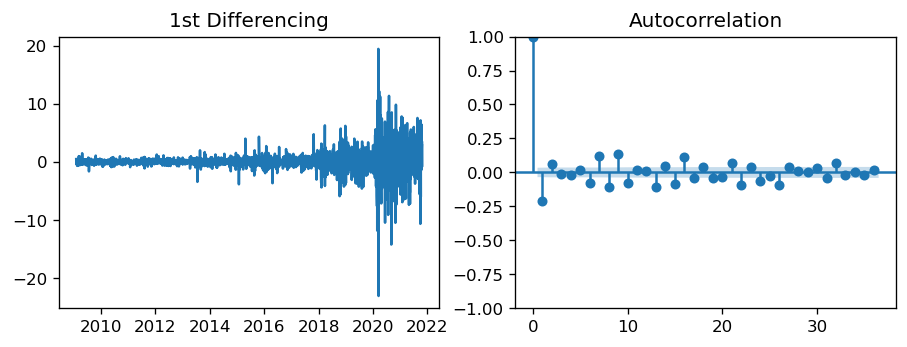

In [18]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(msft_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(msft_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# First Simple Model

## Train-Test Split

In [20]:
n = int(len(msft_close) * 0.80)
train = msft_close[:n]
test = msft_close[n:]

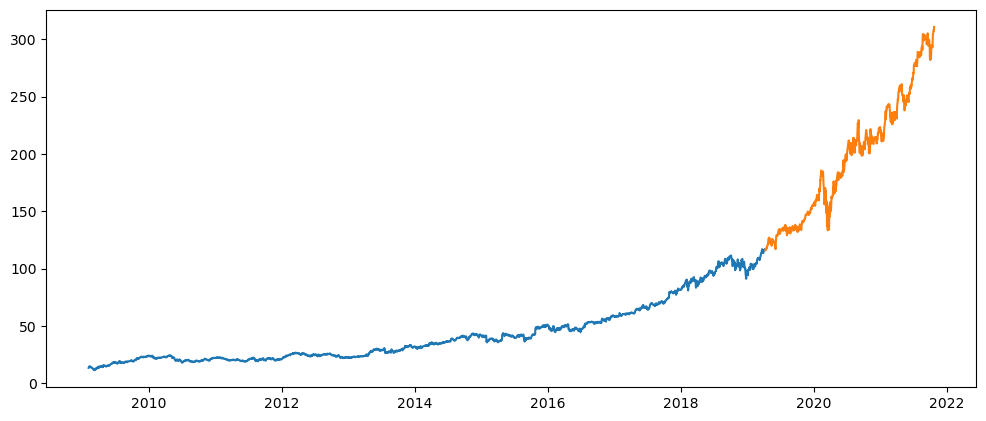

In [21]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [22]:
model = SARIMAX(msft_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6247.944
Date:                Tue, 26 Oct 2021   AIC                          12501.887
Time:                        11:42:15   BIC                          12520.103
Sample:                             0   HQIC                         12508.417
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2909      0.026    -11.091      0.000      -0.342      -0.240
ma.L1          0.0865      0.028      3.099      0.002       0.032       0.141
sigma2         2.8962      0.022    129.776      0.0

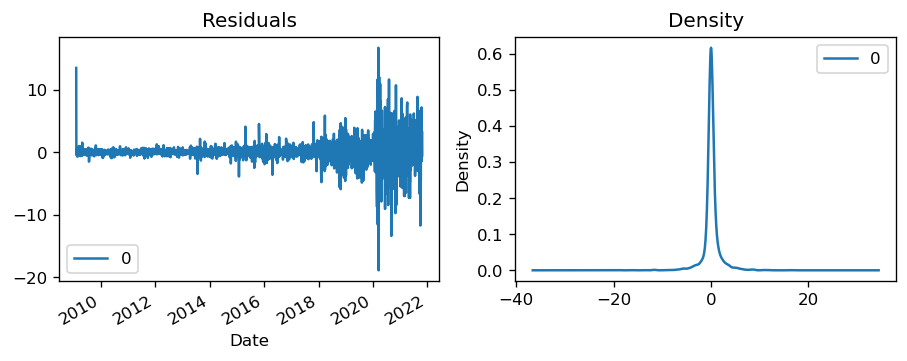

In [23]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [34]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), end=pd.to_datetime('2021-10-21'), dynamic=False)
plt.show()

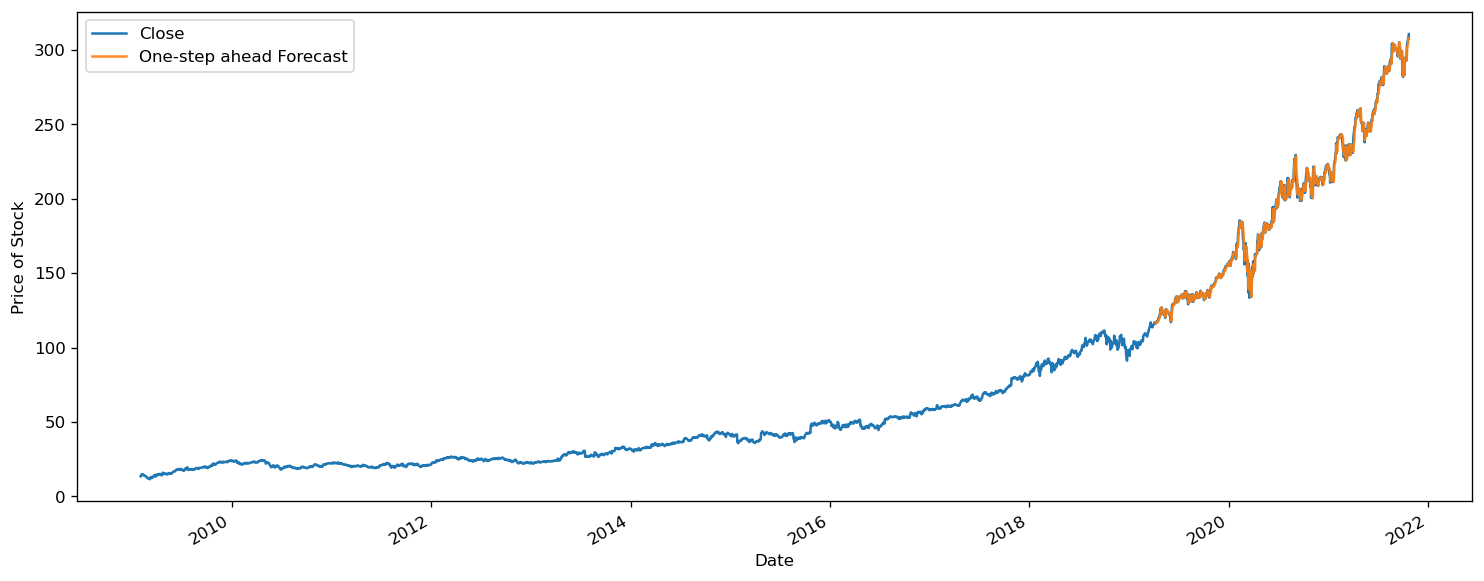

In [35]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = msft_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price of Stock')
plt.legend()

plt.show();

In [36]:
value_forecasted = pred
value_truth = msft_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 3.49


# PMD ARIMA

In [37]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [38]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 2

Estimated differencing term: 2


In [39]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7821.676, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=7043.354, Time=0.54 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7819.676, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6530.503, Time=0.65 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6376.944, Time=0.78 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6309.734, Time=0.97 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6200.456, Time=1.24 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=6098.298, Time=1.30 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.25 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.74 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=6096.298, Time=0.62 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6198.456, Time=0.60 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=inf, Time=5

In [40]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(6, 2, 0)   Log Likelihood               -3041.149
Date:                Tue, 26 Oct 2021   AIC                           6096.298
Time:                        11:46:20   BIC                           6137.235
Sample:                             0   HQIC                          6111.142
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9495      0.009   -101.242      0.000      -0.968      -0.931
ar.L2         -0.8499      0.012    -69.311      0.000      -0.874      -0.826
ar.L3         -0.6290      0.017    -38.073      0.0

In [41]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 14.284442049892645
SMAPE: 1.4062388094805751


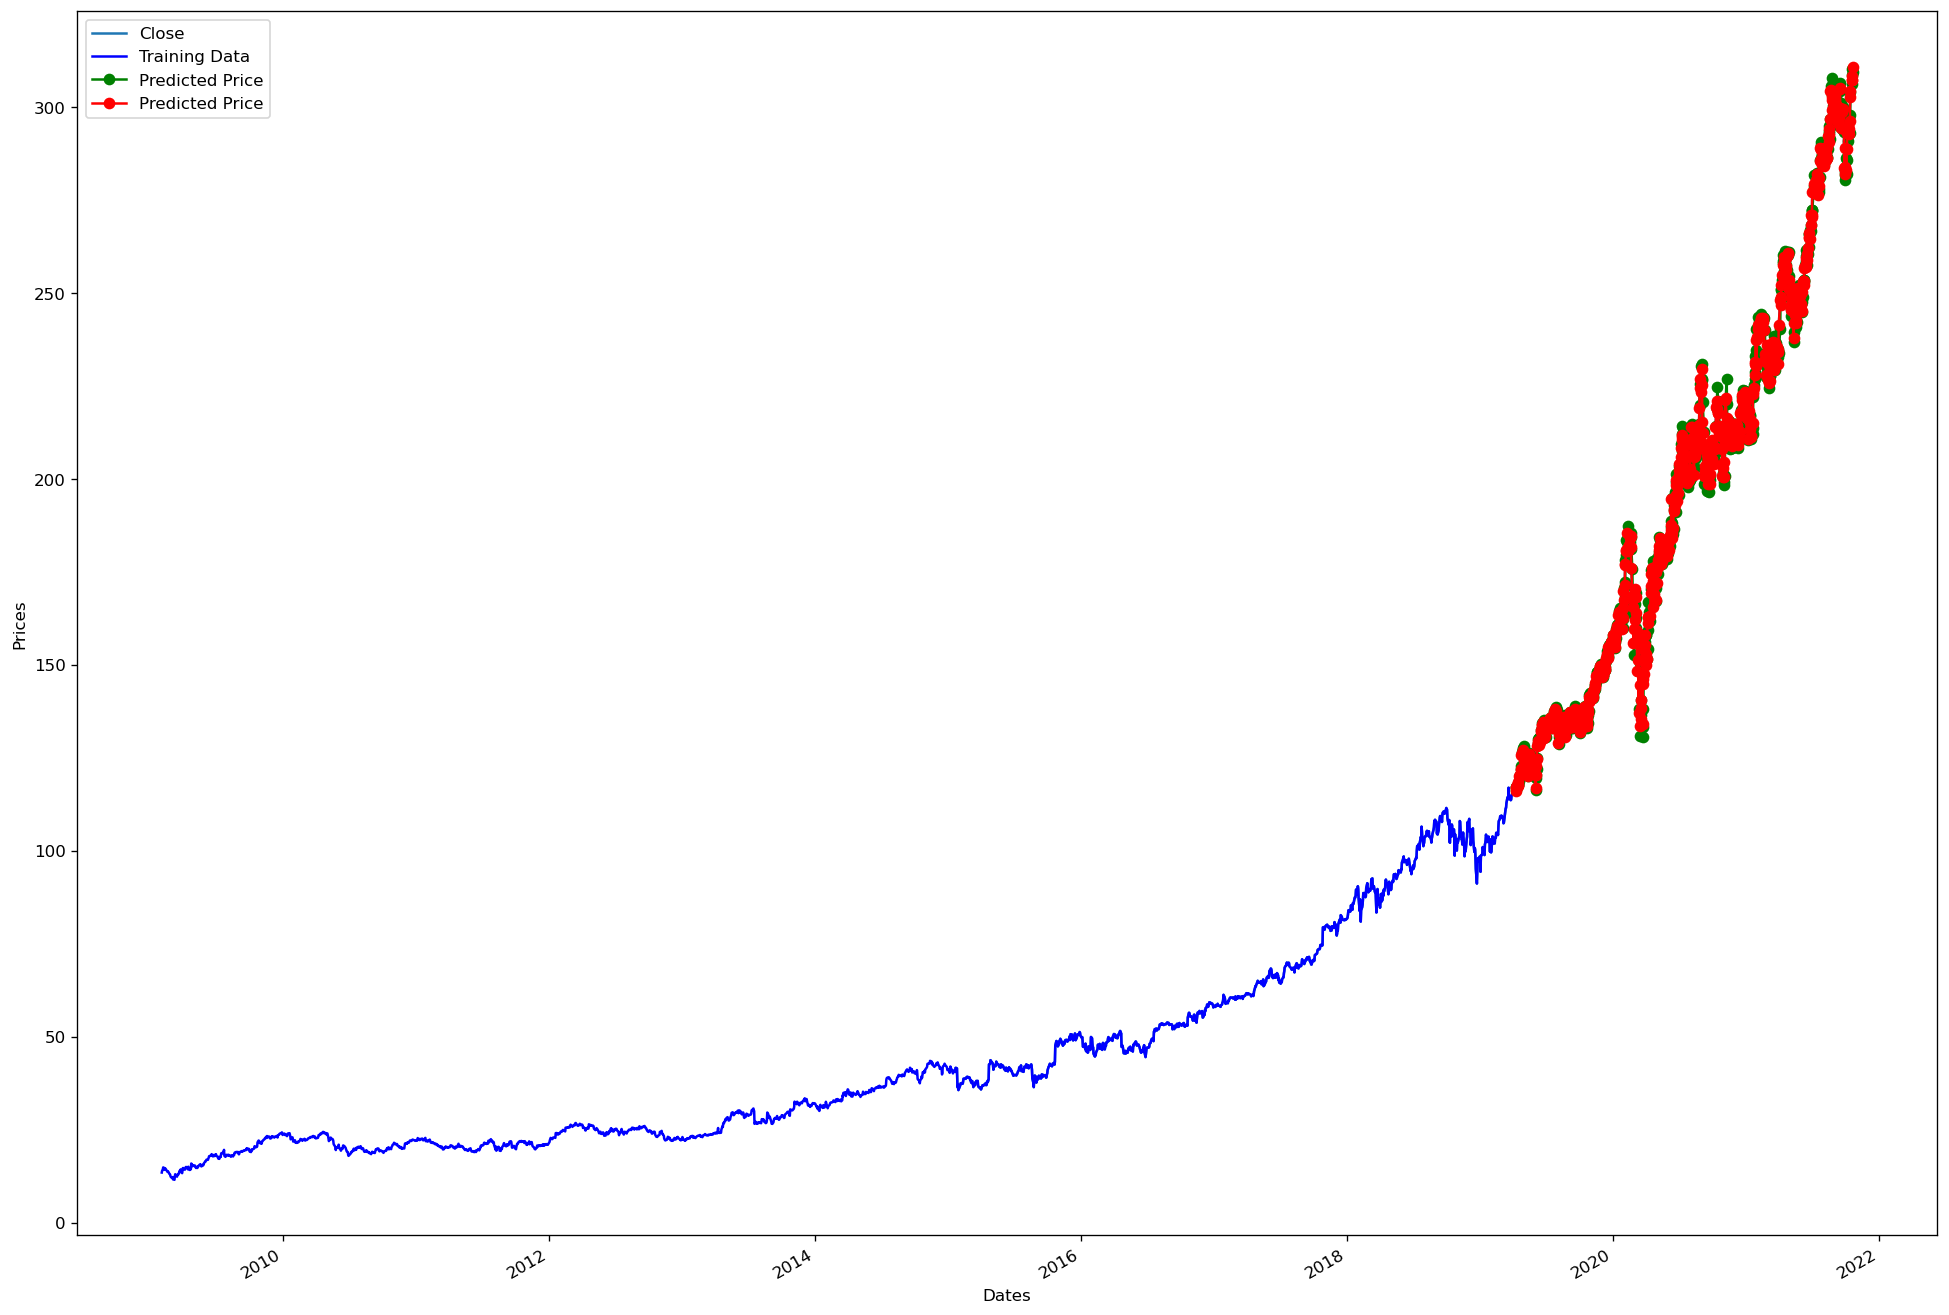

In [42]:
ax = msft_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [43]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(14.284442049892645), 2)))

The Root Mean Squared Error of prediction is 3.78


## SARIMAX PMDARIMA

In [46]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

In [ ]:
ax = msft_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [ ]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt('fill out'), 2)))

## FBPROPHET

In [ ]:
msft_close = msft[['Close']]

In [ ]:
msft = msft_close.reset_index()

In [ ]:
msft.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
msft['ds'] = pd.to_datetime(msft['ds'])
msft['y']=msft['y'].astype(float)

In [ ]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
df_prophet.fit(msft)

In [ ]:
fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

In [ ]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [ ]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Microsoft Price');

In [ ]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()